# Klasyfikacja obrazu za pomocą konwolucyjnych sieci neuronowych, część II

## Załadowanie bibliotek

In [0]:
# !ln -s /content/plots_wcz.py /content/fastai/fastai/plots_wcz.py
# !ln -s /content/imports_wcz.py /content/fastai/fastai/imports_wcz.py
# !ln -s /content/model_wcz.py /content/fastai/fastai/model_wcz.py
# cd /content/fastai

In [0]:
# Umieść je na górze każdego notatnika, aby uzyskać automatyczne ponowne ładowanie
%reload_ext autoreload
%autoreload 2

#matplotlib setup
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import matplotlib.style
import matplotlib as mpl
mpl.style.use('default')
mpl.style.use('seaborn-ticks')
# %config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import shutil as sh

# Ten plik zawiera wszystkie główne biblioteki zewnętrzne, których użyjemy
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [0]:
# cd /content

# Proste kroki do wytrenowania światowej klasy klasyfikatora obrazu

1. Włącz augmentację danych oraz cache aktywacji (precompute=True)
1. Użyj `lr_find()`, aby znaleźć najwyższe tempo uczenia się, przy którym strata (loss) jeszcze maleje
1. Trenuj ostatnią warstwę na cache'owanych aktywacjach przez 1-2 epoki
1. Trenuj ostatnią warstwę z augmentacją danych (tj. precompute=False) przez 2-3 epoki z cycle_len=1
1. Odblokuj wszystkie warstwy, używając `unfreeze()`
1. Ustaw dla wcześniejszych warstw 3x-10x mniejsze tempo uczenia się niż dla kolejnych wyższych warstw
1. Ponownie użyj `lr_find()`
1. Trenuj całą sieć z cycle_mult=2 aż do przetrenowania (over-fitting)

# Idea strojenia wytrenowanej sieci (fine-tuning)

`ConvLearner.pretrained` buduje *ucznia*, który zawiera wcześniej wytrenowany model. Ostatnia warstwa modelu musi zostać zastąpiona warstwą odpowiednich wymiarów. Ten model został wytrenowany dla 1000 klas, a ostateczna warstwa prognozuje wektor z 1000-cem prawdopodobieństw. Model dla old polish cars musi oddać wektor dwuwymiarowy. Poniższy schemat pokazuje na przykładzie, w jaki sposób zostało to zrobione w jednej z najwcześniej odnoszących sukces sieci konwolucyjnych CNN. Warstwa "FC8" zostanie tutaj zastąpiona nową warstwą z 10 wyjściami.

<img src="https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg" width="500">
[original image](https://image.slidesharecdn.com/practicaldeeplearning-160329181459/95/practical-deep-learning-16-638.jpg)

Uczymy się *parametrów* poprzez dopasowanie modelu do danych. *Hiperparametr* to inny rodzaj parametru, którego nie można bezpośrednio nauczyć się ze zwykłego procesu treningowego. Parametry te wyrażają właściwości modelu "wyższego poziomu", takie jak jego złożoność, czy jak szybko ma się uczyć. Dwa przykłady hiperparametrów to *tempo uczenia się* i *liczba epok*.

Podczas iteracyjnego trenowania sieci neuronowej, *wsad (batch)* lub *mini-wsad (mini-batch)* jest podzbiorem treningowych próbek użytych w jednej iteracji metody stochastycznego gradientu prostego, ang. Stochastic Gradient Descent (SGD). *Epoka* to pojedyncze przejście przez cały zestaw treningowy, na nią składa się wiele iteracji SGD.

Możemy teraz *dopasować (fit)* model; to znaczy, użyć *metody gradientu prostego (gradient descent)*, aby znaleźć najlepsze parametry dla *w pełni połączonej warstwy (fully connected layer - FC)*, którą dodaliśmy, aby oddzielać zdjęcia marek samochodów od siebie. Musimy podać dwa hipertermery: *tempo uczenia się (learning rate)* (zazwyczaj 1e-2 lub 1e-3 jest dobrym punktem wyjścia, później przyjrzymy się temu bliżej) i *liczbę epok* (możesz podać większą liczbę i po prostu przerwij trening, gdy zauważysz, że dokładność (accuracy) już się nie poprawia, a następnie uruchom ponownie trening z liczbą epok, którą ustaliłeś).

## Mój dataset: 'Old Polish Cars v5'

Tym razem wytrenujemy model, który pozwoli rozróżnić 10 marek starych polskich samochodów. Dostępne jest 7300 oznakowanych zdjęć samochodów do trenowania i 800 w zestawie testowym, które musimy spróbować oznakować.

In [0]:
PATH = "/content/data/old_polish_cars/old_polish_cars_v5_photos-512-split/"

In [4]:
ls -lah /content/data/old_polish_cars

total 349M
drwxr-xr-x 3 root root  4.0K Oct 17 15:46 ./
drwxr-xr-x 3 root root  4.0K Oct 17 15:45 ../
drwxr-xr-x 4  501 staff 4.0K Jun  5 14:19 old_polish_cars_v5_photos-512-split/
-rw-r--r-- 1 root root  349M Oct 17 15:46 old_polish_cars_v5_photos-512-split.tgz


## Sprawdzenie, czy dataset jest dostępny

In [4]:
!ls {PATH}

models	tmp  train  valid


In [5]:
!ls {PATH}valid

Autobus Jelcz MZK     Fiat 125p		FSC Zuk      FSO Warszawa  Syrena 105
Autobus Jelcz Ogorek  Fiat 126p Maluch	FSO Polonez  Gazik	   ZSD Nysa


In [6]:
files = !ls {PATH}valid/"FSO Warszawa" | head
files

['15_1487453323.84.jpg',
 '21_1487453327.45.jpg',
 '32_1487453346.6_ddd.jpg',
 '33_1487453347.16_ddd_ddd.jpg',
 '44_1487453358.99_ddd.jpg',
 '46_1487453360.68_ddd.jpg',
 '48_1487453364.29_ddd_ddd.jpg',
 '56_1487453384.48_ddd_ddd.jpg',
 '63_1487453393.01_ddd_ddd.jpg',
 '67_1487453399.4.jpg']

In [7]:
files[9]

'67_1487453399.4.jpg'

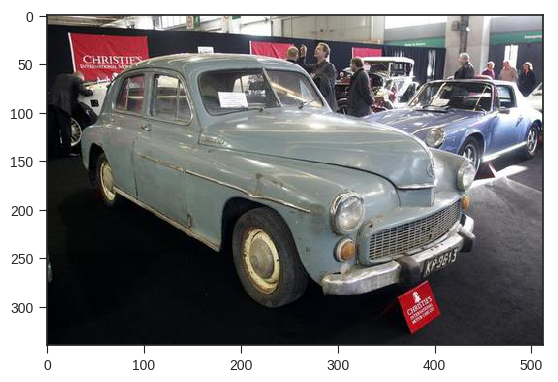

In [8]:
img = plt.imread(f'{PATH}valid/FSO Warszawa/{files[9]}')
plt.imshow(img);

# Trenowanie klasyfikatora

## 1) Włącz augmentację danych oraz cache aktywacji

augmentacja danych: `aug_tfms=transforms_side_on, max_zoom=1.1`

cache aktywacji: `precompute=True`

In [0]:
sz=224  # sz=128
arch=resnet34

tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [5]:
sz=224  # sz=128
arch=resnet34

data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 74519427.05it/s]


100%|██████████| 16/16 [00:08<00:00,  3.78it/s]


## 2) Znajdź tempo uczenia się

*Tempo uczenia się* określa, jak szybko lub jak wolno chcesz aktualizować *wagi* (lub *parametry*). Tempo uczenia się jest jednym z najtrudniejszych parametrów do ustawienia, ponieważ ma znaczący wpływ na wydajność modelu.

Metoda `learn.lr_find()` pomaga znaleźć optymalne tempo uczenia się. Wykorzystuje technikę opracowaną w 2015 roku, opisaną w publikacji [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), gdzie po prostu ciągle zwiększamy tempo uczenia się, zaczynając od bardzo małej wartości, kończąc kiedy strata przestaje maleć. Możemy stworzyć wykres tempa uczenia się poprzez wszystkie porcje danych jednej epoki, aby zobaczyć, jak to wygląda.

Najpierw tworzymy nowego ucznia `learn`, ponieważ chcemy wiedzieć, jak ustawić tempo uczenia się dla nowego (niewytrenowanego) modelu.

In [6]:
lrf = learn.lr_find()

Widget Javascript not detected.  It may not be installed or enabled properly.


 81%|████████  | 112/138 [00:02<00:00, 29.32it/s, loss=1.62]


Nasz obiekt `learn` ma atrybut `sched`, który zawiera naszego 'planistę' szybkości uczenia się i ma kilka przydatnych wykresów, w tym:



In [0]:
mpl.style.use('bmh')
learn.sched.plot_lr()

Zauważ, że na poprzednim wykresie jedna *iteracja* to iteracja (lub 'mini-batch') algorytmu SGD. W jednej epoce mamy `num_batch_samples/num_samples` iteracji SGD.

Możemy rzucić okiem wykres straty (loss) w stosunku do tempa uczenia się (learning rate), aby zobaczyć, gdzie zmniejsza się nasza strata:

In [0]:
learn.sched.plot()

Strata wciąż wyraźnie maleje dla `lr=1e-2 (0.01)`, więc tego użyjemy. Zwróć uwagę, że optymalne tempo uczenia się może się zmieniać podczas treningu modelu, więc możesz chcieć ponownie uruchomić tę funkcję co jakiś czas.

wybrany lr=0.08

In [0]:
0.8*10**-1

## 3) Wstępnie wytrenuj ostatnią warstwę
Trenuj ostatnią warstwę na cache'owanych aktywacjach przez 1-2 epoki.

Domyślnie, gdy tworzymy ucznia (`learn`), ustawia on wszystkie oprócz ostatniej warstwy na *zamrożone* (ang. frozen). Oznacza to, że kiedy wywołujemy `fit()`, uczeń aktualizuje wagi tylko w ostatniej warstwie.

In [9]:
learn.fit(0.08, 3)  # stałe tempo uczenia się

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   accuracy   
    0      0.719061   0.356234   0.873469  
    1      0.444371   0.305502   0.897959  
    2      0.333374   0.276214   0.902041  



[array([0.27621]), 0.9020408168130991]

In [0]:
learn.save('224_initial')

In [19]:
f'{PATH}models'

'/content/data/old_polish_cars/old_polish_cars_v5_photos-512-split/models'

In [15]:
ls {PATH}/models

224_initial.h5  tmp.h5


In [0]:
from google.colab import files
files.download('/content/data/old_polish_cars/old_polish_cars_v5_photos-512-split/models/224_initial.h5')

In [0]:
learn.load('224_initial')

## 4) Trenuj ostatnią warstwę z augmentacją danych i hartowaniem tempa uczenia się

### Augmentacja danych

Jeśli spróbujesz trenować przez więcej epok, zauważysz, że zaczynamy *przetrenowywać*, co oznacza, że nasz model uczy się rozpoznawać konkretne obrazy w zbiorze treningowym, zamiast generalizować tak, że uzyskamy dobre wyniki również na zestawie walidacyjnym. Jednym ze sposobów rozwiązania tego problemu jest faktyczne stworzenie większej ilości danych, dzięki *augmentacji danych*. Chodzi o losową modyfikację obrazów w sposób, który nie powinien wpływać na ich interpretację, takich jak poziome odbijanie, powiększanie i obracanie.

Możemy to zrobić, przekazując `aug_tfms` (*augmentation transforms*) do `tfms_from_model()`, z listą funkcji do zastosowania, które losowo zmieniają obraz, jak tylko chcemy. W przypadku zdjęć, które są w dużej mierze robione z boku (np. większość zdjęć samochodów, w przeciwieństwie do zdjęć zrobionych od góry, takich jak zdjęcia satelitarne), możemy użyć wstępnie zdefiniowanej listy funkcji `transforms_side_on`. Możemy również określić losowe powiększanie obrazów do określonej skali, dodając parametr `max_zoom`.

In [0]:
# tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [0]:
# transformers for training
tfms[0].tfms

In [0]:
# transformers for validation
tfms[1].tfms

In [0]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [0]:
ims = np.stack([get_augs() for i in range(6)])

In [0]:
plots(ims, rows=2)

Trenuj ostatnią warstwę z augmentacją danych (tj. `precompute=False`) przez 2-3 epoki z `cycle_len=1`

In [0]:
learn.precompute=False  # użyj augmentacji danych
learn.fit(0.08, 3, cycle_len=1)

### Metoda stochastycznego gradientu prostego z restartami

Co to jest parametr `cycle_len`? To, co tutaj robimy, to metoda *stochastycznego gradientu prostego z restartami (ang. stochastic gradient descent with restarts - SGDR)*, jest to wariant *hartowania szybkości uczenia (ang. learning rate annealing)*, która stopniowo zmniejsza tempo uczenia się w miarę postępu treningu. To pomaga, bo gdy zbliżamy się do optymalnych wag, chcemy podejść tam mniejszymi krokami.

Jednakże możemy znaleźć się w części przestrzeni wag, która nie jest bardzo odporna - to znaczy niewielkie zmiany wag mogą spowodować duże zmiany w stracie. Chcemy zachęcić nasz model do znalezienia części przestrzeni wag, które są zarówno dokładne, jak i stabilne. Dlatego od czasu do czasu zwiększamy szybkość uczenia się (jest to "restart" w "SGDR"), co zmusi model do przejścia do innej części przestrzeni wag, jeśli obecny obszar jest "spiczasty". Oto wykres tego, jak to może wyglądać, jeśli zresetujemy tempo uczenia się 3 razy (w tej publikacji nazywają to "cyklicznym harmonogramem LR", ang. 'cyclic LR schedule'):

![SGDR](https://raw.githubusercontent.com/fastai/fastai/master/courses/dl1/images/sgdr.png)
(Z publikacji [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

Liczba epok pomiędzy resetowaniem tempa uczenia się jest ustalana przez `cycle_len`, a liczba razy, kiedy to się dzieje, jest określana jako *liczba cykli*, i jest tym, co faktycznie przekazujemy jako drugi parametr do `fit()`. Oto jak wyglądało nasze rzeczywiste tempo uczenia się:

In [0]:
learn.sched.plot_lr()

Nasza strata na zestawie walidacyjnym nie ulega znacznej poprawie, więc prawdopodobnie nie ma potrzeby dalszego trenowania samej ostatniej warstwy.

Ponieważ w tym momencie mamy już całkiem niezły model, możemy chcieć go zapisać, abyśmy mogli go załadować ponownie później bez trenowania od początku.

In [0]:
learn.save('224_lastlayer')

In [0]:
learn.load('224_lastlayer')

## 5) Dostrój (fine-tune) wcześniejsze warstwy i 6) różnicowo hartuj tempa uczenia się
Odblokuj wszystkie warstwy, używając `unfreeze()`.<br/>
Ustaw dla wcześniejszych warstw 3x-10x mniejsze tempo uczenia się niż dla kolejnych wyższych warstw.

Teraz, gdy mamy już wytrenowaną dobrą warstwę końcową, możemy spróbować dostroić pozostałe warstwy. Aby powiedzieć uczniowi, że chcemy odblokować pozostałe warstwy, wystarczy użyć `unfreeze()`.

In [0]:
learn.unfreeze()

Zauważ, że pozostałe warstwy zostały *już wcześniej* wytrenowane do rozpoznawania zdjęć imagenetowych (podczas gdy nasze końcowe warstwy zostały losowo zainicjowane), więc chcemy zadbać o to, aby nie zniszczyć dokładnie wyregulowanych wag, które już tam są.

Ogólnie mówiąc, wcześniejsze warstwy (jak już widzieliśmy) mają funkcje działające bardziej ogólnie. Dlatego spodziewamy się, że będą potrzebowały mniejszego dostrojenia dla nowego zestawu danych. Z tego powodu użyjemy różnych temp uczenia się dla różnych warstw: pierwsze kilka warstw będzie na poziomie 1e-4, środkowe warstwy na 1e-3, a nasze warstwy FC pozostawimy na 1e-2, tak jak poprzednio. Nazywamy to *zróżnicowanymi tempami uczenia się* ang. "differential learning rates", chociaż, o ile nam wiadomo, nie ma standardowej nazwy dla tej technologii w literaturze.

In [0]:
lr = np.array([0.0008, 0.008, 0.08])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

Kolejną sztuczką, której tutaj użyliśmy jest dodanie parametru `cycle_mult`. 

Rzuć okiem na poniższy wykres i sprawdź, czy dojdziesz, co ten parametr robi:

In [0]:
learn.sched.plot_lr()

Zauważ, że to, co wykreślono powyżej, to tempo uczenia się *ostatnich warstw*. Współczynniki uczenia się wcześniejszych warstw są ustalane na mnożnikach względem wybranego wcześniej tempa dla ostatnich warstw (tj. pierwsze warstwy mają 100x mniejsze, a warstwy średnie 10x mniejsze tempo uczenia się, skoro ustawiamy `lr=np.array([1e-4,1e-3,1e-2])`.

In [0]:
learn.save('224_all')

In [0]:
learn.load('224_all')

## 7) Ponownie użyj lr_find()

In [0]:
lrf = learn.lr_find()

In [0]:
learn.sched.plot()

In [0]:
lr = np.array([0.00001, 0.0001, 0.001])

## 8) Trenuj całą sieć z cycle_mult=2 aż do przetrenowania (over-fitting)

In [0]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [0]:
learn.save('224_final')

In [0]:
learn.load('224_final')

# Kontrola jakości na zestawie walidacyjnym

### Prognoza z użyciem TTA (Test Time Augmentation)

Jest jeszcze coś, co możemy zrobić z augmentacją danych: użyj jej podczas *wnioskowania* (czy *testowania*). Nic dziwnego, że jest to znane jako *augmentacja podczas testowania*, ang. "test time augmentation" lub po prostu *TTA*.

TTA po prostu tworzy prognozy nie tylko na obrazach z twojego zbioru walidacyjnego, ale także tworzy prognozy dla pewnej liczby losowo augmentowanych ich wersji (domyślnie używa oryginalnego obrazu wraz z 4 losowo augmentowanymi wersjami). Następnie liczy i używa średniej prognozy z tych obrazów. Aby użyć TTA na zestawie walidacyjnym, możemy skorzystać z metody `TTA()` ucznia.

In [0]:
log_preds_tta, y_tta = learn.TTA()

In [0]:
probs_tta = np.mean(np.exp(log_preds_tta),0)
preds_tta = np.argmax(probs_tta, axis=1)  # from log probabilities to 0 or 1

In [0]:
probs_tta[0:3, :]

In [0]:
# preds_tta[:3]

In [0]:
accuracy_np(probs_tta, y_tta)

Zwykle widać 10-20 procentowy spadek błędu na tym zestawie danych podczas korzystania z TTA w tym momencie, co jest niesamowitym wynikiem dla tak szybkiej i prostej techniki!

### Prognoza bez TTA

In [0]:
# to tworzy prognozę dla zestawu walidacyjnego. Prognozy są w skali logarytmicznej
log_preds = learn.predict()
y = data.val_y

In [0]:
preds = np.argmax(log_preds, axis=1)  # od logarytmu prawdopodobieństwa do 0, 1, ... lub 9
probs = np.exp(log_preds);            # pr(car)

In [0]:
probs[0:3, :]

In [0]:
preds[:150]

In [0]:
print('preds: ', len(preds), preds[0:10], '\nprobs: ', len(probs), probs[0:10])

In [0]:
accuracy_np(probs, y)

## Analiza wyników - tablica pomyłek

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
# use to check TTA predictions
# y = y_tta
# preds = preds_tta

In [0]:
cm = confusion_matrix(y, preds)

mpl.style.use('default')
mpl.style.use('seaborn-ticks')
plot_confusion_matrix(cm, data.classes)

# Koniec

In [0]:
from google.colab import files

# with open('example.txt', 'w') as f:
#   f.write('some content')

files.download('/content/data/....')